## accessing CMIP6 data in 'the cloud'

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2

In [4]:
import xarray as xr
import numpy as np
import dask
import intake
import fsspec
from dask.diagnostics import ProgressBar

### small function to drop all variables with `_bounds` and `_bnds` suffix and remove the 'height' coordinate

In [5]:
def cleanup(dset):
    drop_vars = [vname for vname in dset.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    dset = dset.drop(drop_vars)
    if 'height' in dset.coords: 
        dset = dset.drop('height')
    return dset 

[Intake](https://github.com/intake/intake) is a package for finding, investigating, loading and disseminating data. 

[Intake ESM ](https://intake-esm.readthedocs.io/en/latest/index.html) is an experimental new package that aims to provide a higher-level interface to searching and loading Earth System Model data archives, such as CMIP6

In [6]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [7]:
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514961
dcpp_init_year,60


In [9]:
type(col)

intake_esm.core.esm_datastore

In [10]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [11]:
col.df.columns

Index(['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year', 'version'],
      dtype='object')

### list all the listed SSP 

In [12]:
[eid for eid in col.df['experiment_id'].unique() if 'ssp' in eid]

['ssp585',
 'ssp245',
 'ssp370SST-lowCH4',
 'ssp370-lowNTCF',
 'ssp370SST-lowNTCF',
 'ssp370SST-ssp126Lu',
 'ssp370SST',
 'ssp370pdSST',
 'ssp119',
 'ssp370',
 'esm-ssp585-ssp126Lu',
 'ssp126-ssp370Lu',
 'ssp370-ssp126Lu',
 'ssp126',
 'esm-ssp585',
 'ssp245-GHG',
 'ssp245-nat',
 'ssp460',
 'ssp434',
 'ssp534-over',
 'ssp245-stratO3',
 'ssp245-aer',
 'ssp245-cov-modgreen',
 'ssp245-cov-fossil',
 'ssp245-cov-strgreen',
 'ssp245-covid',
 'ssp585-bgc']

### we are going to see what is available for SSP245, 585 as well as the historical experiments 

In [13]:
expts = ['historical', 'ssp245', 'ssp585']

#### build a query (dictionnary)

In [14]:
query = dict(
    experiment_id=expts,
    table_id='Amon',                           
    variable_id=['tas'],
    member_id = 'r1i1p1f1',                     
)

In [15]:
query

{'experiment_id': ['historical', 'ssp245', 'ssp585'],
 'table_id': 'Amon',
 'variable_id': ['tas'],
 'member_id': 'r1i1p1f1'}

#### search the catalog for entries matching the query 

In [16]:
col_subset = col.search(require_all_on=["source_id"], **query)

In [17]:
col_subset.df.groupby("source_id")[["experiment_id", "variable_id", "table_id"]].nunique()

,experiment_id,variable_id,table_id
source_id,,,
ACCESS-CM2,3,1,1
AWI-CM-1-1-MR,3,1,1
BCC-CSM2-MR,3,1,1
CAMS-CSM1-0,3,1,1
CAS-ESM2-0,3,1,1
CESM2-WACCM,3,1,1
CIESM,3,1,1
CMCC-CM2-SR5,3,1,1
CMCC-ESM2,3,1,1


In [18]:
len(col_subset.df.groupby("source_id")[["experiment_id", "variable_id", "table_id"]].nunique()) 

34

### For the sake of illustration, we will choose the Australian model (ACCESS)

In [19]:
query.update({'source_id':'ACCESS-CM2'})

In [20]:
query

{'experiment_id': ['historical', 'ssp245', 'ssp585'],
 'table_id': 'Amon',
 'variable_id': ['tas'],
 'member_id': 'r1i1p1f1',
 'source_id': 'ACCESS-CM2'}

In [21]:
col_subset = col.search(require_all_on=["source_id"], **query)

In [22]:
col_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp245,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCE...,NaN,20191108
1,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
2,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCE...,NaN,20210317


In [23]:
loc_historical = col_subset.df.query("experiment_id == 'historical'").zstore.values[0]

In [24]:
loc_historical

'gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/tas/gn/v20191108/'

In [25]:
loc_ssp245 = col_subset.df.query("experiment_id == 'ssp245'").zstore.values[0]

In [26]:
loc_ssp245

'gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp245/r1i1p1f1/Amon/tas/gn/v20191108/'

In [27]:
loc_ssp585 = col_subset.df.query("experiment_id == 'ssp585'").zstore.values[0]

In [28]:
loc_ssp585

'gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/Amon/tas/gn/v20210317/'

### open the datasets 

In [29]:
dset_historical = xr.open_zarr(fsspec.get_mapper(loc_historical), consolidated=True)

In [31]:
dset_historical

<xarray.Dataset>
Dimensions:    (lat: 144, bnds: 2, lon: 192, time: 1980)
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(668, 144, 192), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/d893128b-e107-4dcc-b543-46c77896f295
    variable_id:            tas
    variant_label:          r1i1p1f1
    version:                v20191108
    netcdf_tracking_ids:    hdl:21.14100/d893128b-e107-4dcc-b543-46c77896f295
    version_id:             v20191108

In [32]:
dset_historical = cleanup(dset_historical)

In [33]:
dset_historical

<xarray.Dataset>
Dimensions:  (lat: 144, lon: 192, time: 1980)
Coordinates:
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(668, 144, 192), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/d893128b-e107-4dcc-b543-46c77896f295
    variable_id:            tas
    variant_label:          r1i1p1f1
    version:                v20191108
    netcdf_tracking_ids:    hdl:21.14100/d893128b-e107-4dcc-b543-46c77896f295
    version_id:             v20191108

In [34]:
dset_ssp245 = xr.open_zarr(fsspec.get_mapper(loc_ssp245), consolidated=True)
dset_ssp245 = cleanup(dset_ssp245)

In [35]:
dset_ssp585 = xr.open_zarr(fsspec.get_mapper(loc_ssp585), consolidated=True)
dset_ssp585 = cleanup(dset_ssp585)

/home/nicolasf/mambaforge/envs/climatedata/lib/python3.10/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/nicolasf/mambaforge/envs/climatedata/lib/python3.10/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/nicolasf/mambaforge/envs/climatedata/lib/python3.10/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [36]:
dset_historical.chunks

Frozen({'time': (668, 668, 644), 'lat': (144,), 'lon': (192,)})

In [37]:
dset_historical = dset_historical.chunk({'time':-1, 'lat':20, 'lon':20})

In [38]:
hist_climatology = dset_historical.sel(time=slice('1991','2020'))

In [39]:
hist_climatology = hist_climatology.groupby(hist_climatology.time.dt.month).mean('time')

In [40]:
hist_anomalies = dset_historical.groupby(dset_historical.time.dt.month) - hist_climatology

/home/nicolasf/mambaforge/envs/climatedata/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


In [41]:
weights = np.cos(np.deg2rad(hist_anomalies.lat))
weights.name = "weights"
weights

<xarray.DataArray 'weights' (lat: 144)>
array([0.01090809, 0.03271908, 0.0545145 , 0.07628397, 0.09801714,
       0.11970366, 0.1413332 , 0.16289547, 0.18438022, 0.20577721,
       0.22707626, 0.24826724, 0.26934005, 0.29028468, 0.31109114,
       0.33174954, 0.35225005, 0.3725829 , 0.39273843, 0.41270703,
       0.43247921, 0.45204555, 0.47139674, 0.49052357, 0.50941694,
       0.52806785, 0.54646743, 0.56460693, 0.5824777 , 0.60007124,
       0.61737918, 0.63439328, 0.65110545, 0.66750772, 0.6835923 ,
       0.69935153, 0.7147779 , 0.72986407, 0.74460287, 0.75898728,
       0.77301045, 0.78666571, 0.79994657, 0.81284668, 0.82535993,
       0.83748035, 0.84920218, 0.86051983, 0.87142793, 0.88192126,
       0.89199486, 0.90164391, 0.91086382, 0.91965022, 0.92799891,
       0.93590593, 0.9433675 , 0.95038008, 0.95694034, 0.96304514,
       0.96869158, 0.97387698, 0.97859887, 0.98285499, 0.98664333,
       0.98996208, 0.99280967, 0.99518473, 0.99708613, 0.99851298,
       0.99946459, 0.99994051, 0.99994051, 0.99946459, 0.99851298,
       0.99708613, 0.99518473, 0.99280967, 0.98996208, 0.98664333,
       0.98285499, 0.97859887, 0.97387698, 0.96869158, 0.96304514,
       0.95694034, 0.95038008, 0.9433675 , 0.93590593, 0.92799891,
       0.91965022, 0.91086382, 0.90164391, 0.89199486, 0.88192126,
       0.87142793, 0.86051983, 0.84920218, 0.83748035, 0.82535993,
       0.81284668, 0.79994657, 0.78666571, 0.77301045, 0.75898728,
       0.74460287, 0.72986407, 0.7147779 , 0.69935153, 0.6835923 ,
       0.66750772, 0.65110545, 0.63439328, 0.61737918, 0.60007124,
       0.5824777 , 0.56460693, 0.54646743, 0.52806785, 0.50941694,
       0.49052357, 0.47139674, 0.45204555, 0.43247921, 0.41270703,
       0.39273843, 0.3725829 , 0.35225005, 0.33174954, 0.31109114,
       0.29028468, 0.26934005, 0.24826724, 0.22707626, 0.20577721,
       0.18438022, 0.16289547, 0.1413332 , 0.11970366, 0.09801714,
       0.07628397, 0.0545145 , 0.03271908, 0.01090809])
Coordinates:
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
Attributes:
    axis:           Y
    bounds:         lat_bnds
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north

In [42]:
weighted_mean = hist_anomalies['tas'].weighted(weights)

In [43]:
weighted_mean = weighted_mean.mean(("lon", "lat"))

In [44]:
with ProgressBar():
    weighted_mean.compute()

[########################################] | 100% Completed |  3min 57.8s


In [45]:
weighted_mean_smooth = weighted_mean.rolling(time=12*5, center=True).mean().dropna("time")

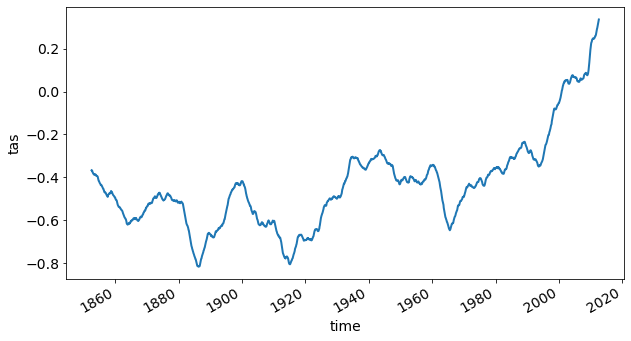

In [46]:
weighted_mean_smooth.plot()